In [313]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from collections import deque

# Node Class represents a state in the search tree.
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state  # The current position of the agent in the grid.
        self.parent = parent  # The node in the search tree that generated this node.
        self.action = action  # The action taken to get to this state.
        self.path_cost = path_cost  # Cost from the start node to this node.

    # Comparison operator for priority queue.
    def __lt__(self, other):
        return self.path_cost < other.path_cost

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]


In [314]:
def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points a and b.

    Parameters:
    - a: Tuple representing the x and y coordinates of point a (e.g., (x1, y1))
    - b: Tuple representing the x and y coordinates of point b (e.g., (x2, y2))

    Returns:
    - The Manhattan distance between points a and b.
    """
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

In [315]:
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid  # The grid layout where 1 represents an obstacle and 0 is free space.
        self.initial = start  # Starting position of the agent.
        self.goal = goal  # Goal position the agent aims to reach.

    # Returns the possible actions from a given state.
    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        # Remove impossible actions based on grid boundaries and obstacles.
        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    # Returns the state resulting from taking a given action at a given state.
    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    # Checks if the goal has been reached.
    def is_goal(self, state):
        return state == self.goal

In [316]:
class Agent:
    def __init__(self, env):
        self.env = env  # The environment in which the agent operates.
        self.battery = 100 # int((np.random.randint(100))/10)*10 Initial battery level

    #battery section
    def recharge(self):
        self.battery = 100
    
    def current_charge(self):
        return self.battery
    
    # Performs BFS search to find a path from the initial state to the goal.
    def bfs_search(self):
        frontier = deque([Node(self.env.initial)])  # FIFO queue for BFS.
        came_from = {self.env.initial: None}  # Tracks how we reached each node.

        while frontier:
            current_node = frontier.popleft()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                if new_state not in came_from:
                    frontier.append(Node(new_state, current_node, action))
                    came_from[new_state] = current_node.state

        return []
    
    # This is a_star_search 
    def a_star_search(self):
        # The start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)  # Priority is f-cost, initially the heuristic cost from start to goal
        came_from = {self.env.initial: None}  # Tracks the best path to a node
        cost_so_far = {self.env.initial: 0}  # Tracks the g-cost (cost so far to reach a node)

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)  # f-cost = g-cost + h-cost
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return []
    
    # Performs Uniform Cost Search to find the lowest cost path from the initial state to the goal.
    def uniform_cost_search(self):
        frontier = PriorityQueue()  # Priority queue for UCS.
        frontier.put(Node(self.env.initial, path_cost=0), 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state)

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity; adjust if varying costs.
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost), priority)
                    came_from[new_state] = current_node.state

        return []

    # Reconstructs the path from start to goal by following the came_from links.
    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]

        path.append(self.env.initial)  # Start is not included in the came_from map.
        path.reverse()  # Reverse to get the path from start to goal.
        return path
    
    # Battery Charging point and management
    def battery_manager(self, path):
        self.recharge()
        charge = []
        charging_point = []

        for i in range(len(path)):
            if self.current_charge() <= 10:
                self.recharge()
                charging_point.append(path[i])
                charge.append(self.battery)  
            elif path[i] != (0, 0):
                self.battery = self.current_charge() - 10
                charge.append(self.battery)
                
        return charging_point, charge 


In [317]:
def visualize_grid_and_path(grid, path, charging_point, charge):
    grid_array = np.array(grid)  # Convert grid to numpy array for easy plotting.
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)  # Grid background.
    start = path[0]
    goal = path[-1]
    ax.plot(start[1], start[0], 'bs', markersize=10)  # Start position in blue.
    ax.plot(goal[1], goal[0], 'gs', markersize=10)  # Goal position in green.
    xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
    ax.plot(ys, xs, 'r:', linewidth=2)  # Plot the path in red.
    if charging_point is not None: # Charging point
        xa, ya = zip(*charging_point)
        ax.plot(ya, xa, 'co', markersize=10)
    for i in range(len(charge)):
        plt.text(ys[i+2], xs[i+2], charge[i], ha = "left")
    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()

This is the solution using Uniform Cost Search algorithm
Solution Path: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, 4), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (7, 8), (8, 8), (9, 8), (9, 9)]
Charging Points: [(6, 4)]


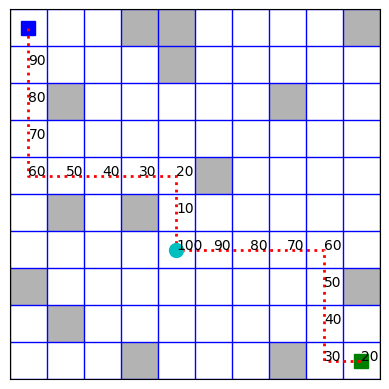

This is the solution using A* Search algorithm
Solution Path: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (5, 4), (6, 4), (6, 5), (6, 6), (7, 6), (7, 7), (7, 8), (8, 8), (9, 8), (9, 9)]
Charging Points: [(6, 4)]


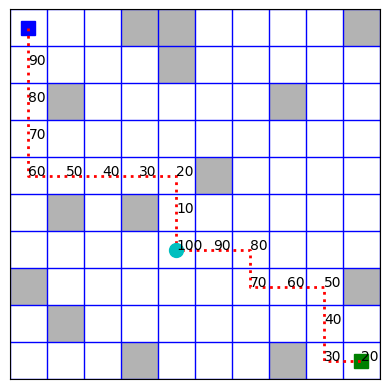

In [318]:
def generate_random_grid(size, obstacle_probability):
    return np.random.choice([0, 1], size=(size, size), p=[1-obstacle_probability, obstacle_probability])

# Define the size of the grid and the probability of an obstacle in each cell
grid_size = 10
obstacle_probability = 0.2  # 20% chance of being an obstacle

# Generate a random grid
grid = generate_random_grid(grid_size, obstacle_probability)

# Define start and goal positions
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)

# Ensure start and goal are not obstacles
grid[start] = 0
grid[goal] = 0

# Create the environment and agent
environment = Environment(grid, start, goal)
agent = Agent(environment)

# Solve the problem with the UCS algorithm
print("This is the solution using Uniform Cost Search algorithm")
solution_path_ucs = agent.uniform_cost_search()
charging_point, charge = agent.battery_manager(solution_path_ucs)
print("Solution Path:", solution_path_ucs)
print("Charging Points:", charging_point)

# Visualize the solution
visualize_grid_and_path(grid, solution_path_ucs, charging_point, charge) 

# Solve the problem with the A* algorithm
print("This is the solution using A* Search algorithm")
solution_path_a_star = agent.a_star_search()
charging_point, charge = agent.battery_manager(solution_path_a_star)
print("Solution Path:", solution_path_a_star)
print("Charging Points:", charging_point)

# Visualize the solution
visualize_grid_and_path(grid, solution_path_a_star, charging_point, charge)